In [1]:
# from sklearn.datasets import make_multilabel_classification
from torch.utils.data import Dataset
import json
import numpy as np
import torch
import time
from tqdm import tqdm

from preprocessing import for_train

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, y = for_train("coauthor")

delet some useless data: 100%|██████████| 25793/25793 [00:00<00:00, 357689.95it/s]


Number of instance with label :  7460
Number of instance without label(remain) :  1894


authors: 100%|██████████| 25793/25793 [00:03<00:00, 6675.43it/s]


In [3]:
print(X.shape)

N_FEATURES = X.shape[1]

torch.Size([9354, 21146])


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)

print("Train:")
print("     X_train : ", X_train.shape)
print("     y_train : ", y_train.shape)
print("Test_Kaggle:")
print("     X_test  : ", X_test.shape)
print("     y_test  : ", y_test.shape)


Train:
     X_train :  torch.Size([7483, 21146])
     y_train :  torch.Size([7483, 100])
Test_Kaggle:
     X_test  :  torch.Size([1871, 21146])
     y_test  :  torch.Size([1871, 100])


In [5]:
from NN_Models import *

In [6]:
print(f"[INFO]: Number of training samples: {X_train.shape[0]}")
print(f"[INFO]: Number of training features: {X_train.shape[1]}")

# train data loader
train_dataset, train_dataloader = BinaryDataLoader(X_train, y_train, shuffle=True, batch_size=100)

# initialize the model
model = NeuralNetworkCoauthor()

[INFO]: Number of training samples: 7483
[INFO]: Number of training features: 21146


In [7]:
import torch.optim as optim

# learning parameters
optimizer = optim.Adam(params=model.parameters(), lr=0.001) # 学习率衰减 / 学习率震荡
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
epochs = 100

# load the model on to the computation device
model.to(device)

NeuralNetworkCoauthor(
  (fc1): Linear(in_features=21146, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (out): Linear(in_features=512, out_features=100, bias=True)
)

In [8]:
import torch

# start the training
start = time.time()
train_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = train(
        model, train_dataloader, optimizer, loss_fn, train_dataset, device
    )
    train_loss.append(train_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
torch.save(model.state_dict(), 'status/model_authors.pth')

print("="*25)
print(time.time()-start, 's')

Epoch 1 of 100


  0%|          | 0/74 [00:00<?, ?it/s]/Users/messifr/Desktop/Messi/MasterY1S2/sml/project2/COMP90051_Project2/code/multi_layer_models/NN_Models.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  features = torch.tensor(features, dtype=torch.float32)
/Users/messifr/Desktop/Messi/MasterY1S2/sml/project2/COMP90051_Project2/code/multi_layer_models/NN_Models.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label_dict[key] = torch.tensor(labels[i], dtype=torch.float32)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmo

Train Loss: 0.1659
Epoch 2 of 100


75it [00:43,  1.74it/s]                        


Train Loss: 0.0276
Epoch 3 of 100


75it [00:36,  2.05it/s]                        


Train Loss: 0.0231
Epoch 4 of 100


75it [00:35,  2.13it/s]                        


Train Loss: 0.0216
Epoch 5 of 100


75it [00:36,  2.04it/s]                        


Train Loss: 0.0206
Epoch 6 of 100


75it [00:39,  1.90it/s]                        


Train Loss: 0.0200
Epoch 7 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0192
Epoch 8 of 100


75it [00:34,  2.20it/s]                        


Train Loss: 0.0183
Epoch 9 of 100


75it [00:38,  1.96it/s]                        


Train Loss: 0.0172
Epoch 10 of 100


75it [00:42,  1.75it/s]                        


Train Loss: 0.0154
Epoch 11 of 100


75it [00:40,  1.83it/s]                        


Train Loss: 0.0126
Epoch 12 of 100


75it [00:47,  1.60it/s]                        


Train Loss: 0.0094
Epoch 13 of 100


75it [00:45,  1.63it/s]                        


Train Loss: 0.0071
Epoch 14 of 100


75it [00:43,  1.71it/s]                        


Train Loss: 0.0057
Epoch 15 of 100


75it [00:41,  1.80it/s]                        


Train Loss: 0.0049
Epoch 16 of 100


75it [00:44,  1.68it/s]                        


Train Loss: 0.0044
Epoch 17 of 100


75it [00:40,  1.86it/s]                        


Train Loss: 0.0041
Epoch 18 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0039
Epoch 19 of 100


75it [00:39,  1.89it/s]                        


Train Loss: 0.0037
Epoch 20 of 100


75it [00:37,  2.02it/s]                        


Train Loss: 0.0037
Epoch 21 of 100


75it [00:43,  1.74it/s]                        


Train Loss: 0.0036
Epoch 22 of 100


75it [00:39,  1.88it/s]                        


Train Loss: 0.0035
Epoch 23 of 100


75it [00:39,  1.89it/s]                        


Train Loss: 0.0035
Epoch 24 of 100


75it [00:41,  1.81it/s]                        


Train Loss: 0.0034
Epoch 25 of 100


75it [00:39,  1.88it/s]                        


Train Loss: 0.0034
Epoch 26 of 100


75it [00:39,  1.88it/s]                        


Train Loss: 0.0034
Epoch 27 of 100


75it [00:38,  1.93it/s]                        


Train Loss: 0.0034
Epoch 28 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0033
Epoch 29 of 100


75it [00:43,  1.71it/s]                        


Train Loss: 0.0033
Epoch 30 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0033
Epoch 31 of 100


75it [00:41,  1.79it/s]                        


Train Loss: 0.0033
Epoch 32 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0033
Epoch 33 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0033
Epoch 34 of 100


75it [00:45,  1.66it/s]                        


Train Loss: 0.0033
Epoch 35 of 100


75it [00:42,  1.77it/s]                        


Train Loss: 0.0033
Epoch 36 of 100


75it [00:39,  1.91it/s]                        


Train Loss: 0.0033
Epoch 37 of 100


75it [00:41,  1.80it/s]                        


Train Loss: 0.0032
Epoch 38 of 100


75it [00:42,  1.78it/s]                        


Train Loss: 0.0032
Epoch 39 of 100


75it [00:49,  1.52it/s]                        


Train Loss: 0.0032
Epoch 40 of 100


75it [00:51,  1.46it/s]                        


Train Loss: 0.0032
Epoch 41 of 100


75it [00:45,  1.65it/s]                        


Train Loss: 0.0032
Epoch 42 of 100


75it [00:43,  1.73it/s]                        


Train Loss: 0.0032
Epoch 43 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0032
Epoch 44 of 100


75it [00:38,  1.93it/s]                        


Train Loss: 0.0032
Epoch 45 of 100


75it [00:38,  1.95it/s]                        


Train Loss: 0.0032
Epoch 46 of 100


75it [00:39,  1.89it/s]                        


Train Loss: 0.0035
Epoch 47 of 100


75it [00:42,  1.78it/s]                        


Train Loss: 0.0032
Epoch 48 of 100


75it [00:43,  1.74it/s]                        


Train Loss: 0.0032
Epoch 49 of 100


75it [00:43,  1.73it/s]                        


Train Loss: 0.0032
Epoch 50 of 100


75it [00:42,  1.78it/s]                        


Train Loss: 0.0032
Epoch 51 of 100


75it [00:42,  1.78it/s]                        


Train Loss: 0.0032
Epoch 52 of 100


75it [00:40,  1.84it/s]                        


Train Loss: 0.0032
Epoch 53 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0032
Epoch 54 of 100


75it [00:41,  1.80it/s]                        


Train Loss: 0.0032
Epoch 55 of 100


75it [00:41,  1.83it/s]                        


Train Loss: 0.0032
Epoch 56 of 100


75it [00:44,  1.68it/s]                        


Train Loss: 0.0032
Epoch 57 of 100


75it [00:45,  1.66it/s]                        


Train Loss: 0.0032
Epoch 58 of 100


75it [00:45,  1.66it/s]                        


Train Loss: 0.0032
Epoch 59 of 100


75it [00:42,  1.76it/s]                        


Train Loss: 0.0032
Epoch 60 of 100


75it [00:41,  1.79it/s]                        


Train Loss: 0.0032
Epoch 61 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0031
Epoch 62 of 100


75it [00:41,  1.82it/s]                        


Train Loss: 0.0032
Epoch 63 of 100


75it [00:41,  1.81it/s]                        


Train Loss: 0.0032
Epoch 64 of 100


75it [00:42,  1.78it/s]                        


Train Loss: 0.0032
Epoch 65 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0031
Epoch 66 of 100


75it [00:40,  1.85it/s]                        


Train Loss: 0.0032
Epoch 67 of 100


75it [00:49,  1.52it/s]                        


Train Loss: 0.0032
Epoch 68 of 100


75it [00:39,  1.91it/s]                        


Train Loss: 0.0031
Epoch 69 of 100


75it [00:38,  1.95it/s]                        


Train Loss: 0.0031
Epoch 70 of 100


75it [00:38,  1.93it/s]                        


Train Loss: 0.0031
Epoch 71 of 100


75it [00:38,  1.94it/s]                        


Train Loss: 0.0031
Epoch 72 of 100


75it [00:36,  2.07it/s]                        


Train Loss: 0.0031
Epoch 73 of 100


75it [00:34,  2.14it/s]                        


Train Loss: 0.0031
Epoch 74 of 100


75it [00:35,  2.12it/s]                        


Train Loss: 0.0031
Epoch 75 of 100


75it [00:36,  2.05it/s]                        


Train Loss: 0.0031
Epoch 76 of 100


75it [00:40,  1.87it/s]                        


Train Loss: 0.0031
Epoch 77 of 100


75it [00:39,  1.88it/s]                        


Train Loss: 0.0031
Epoch 78 of 100


75it [00:37,  2.00it/s]                        


Train Loss: 0.0031
Epoch 79 of 100


75it [00:38,  1.96it/s]                        


Train Loss: 0.0032
Epoch 80 of 100


75it [00:37,  1.98it/s]                        


Train Loss: 0.0031
Epoch 81 of 100


75it [00:37,  1.99it/s]                        


Train Loss: 0.0031
Epoch 82 of 100


75it [00:37,  1.99it/s]                        


Train Loss: 0.0031
Epoch 83 of 100


75it [00:39,  1.89it/s]                        


Train Loss: 0.0031
Epoch 84 of 100


75it [00:36,  2.03it/s]                        


Train Loss: 0.0031
Epoch 85 of 100


75it [00:36,  2.05it/s]                        


Train Loss: 0.0031
Epoch 86 of 100


75it [00:37,  2.00it/s]                        


Train Loss: 0.0031
Epoch 87 of 100


75it [00:38,  1.97it/s]                        


Train Loss: 0.0031
Epoch 88 of 100


75it [00:38,  1.95it/s]                        


Train Loss: 0.0031
Epoch 89 of 100


75it [00:37,  1.98it/s]                        


Train Loss: 0.0031
Epoch 90 of 100


75it [00:37,  1.98it/s]                        


Train Loss: 0.0031
Epoch 91 of 100


75it [00:37,  2.00it/s]                        


Train Loss: 0.0031
Epoch 92 of 100


75it [00:37,  2.02it/s]                        


Train Loss: 0.0031
Epoch 93 of 100


75it [00:37,  2.02it/s]                        


Train Loss: 0.0031
Epoch 94 of 100


75it [00:36,  2.03it/s]                        


Train Loss: 0.0031
Epoch 95 of 100


75it [00:37,  2.01it/s]                        


Train Loss: 0.0031
Epoch 96 of 100


75it [00:38,  1.95it/s]                        


Train Loss: 0.0031
Epoch 97 of 100


75it [00:38,  1.97it/s]                        


Train Loss: 0.0031
Epoch 98 of 100


75it [00:38,  1.94it/s]                        


Train Loss: 0.0031
Epoch 99 of 100


75it [00:37,  1.98it/s]                        


Train Loss: 0.0031
Epoch 100 of 100


75it [00:37,  2.01it/s]                        


Train Loss: 0.0031
4048.145077943802 s


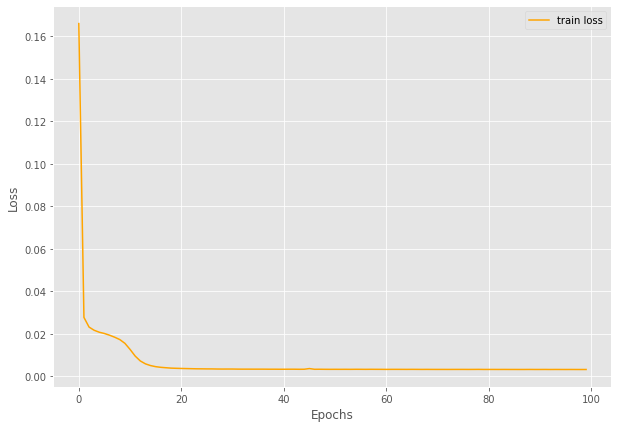

In [9]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

# plot and save the train loss graph
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('outputs/multi_head_binary_loss.png')
plt.show()